# Feladat

A feladat során egy egyszerű Multi-layer Perceptron (MLP) típusú neuronhálót kell betanítani és kiértékelni egy regressziós és egy klasszifikációs feladaton a PyTorch könyvtár segítségével.

A feladat több részfeladatból áll (A - I), melyek egymásra épülnek. A feladat automatikus tesztelőszkripttel rendelkezik és vizsgálja az egyes részfeladatokra adott megoldások helyességét. Éppen ezért, **ne változtasd meg a notebook struktúráját**, ne szedd több részre, illetve ne módosítsd a megírt részeket, csak a megoldásaidat írd be a megfelelő helyre, különben nem fogjuk tudni értékelni! A megoldások az `# Implement your solution BELOW` és `# Implement your solution ABOVE` sorok közé írandók. Ha a megoldott részfeladatok futtatásakor a "Tester: .... OK" felirat megjelenik, _vélhetően_ jó a megoldás.

Tesztelő szkript letöltése, importok.

In [1]:
# Download tester

import copy
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from tester import Tester

###**A**: Az adatbázis betöltése

**Információ az adatbázisról**:
Az adatbázis az UCI Machine Learning Repository-ról származik (http://archive.ics.uci.edu/ml/datasets/Student+Performance). Két portugál középiskolában tanuló diákok néhány adatát és a harmadév végi, év végi jegyeiket (0-20) tartalmazza. A házi feladat keretében, **neuronhálókkal próbálunk a diákok szociális és pénzügyi háttere alapján becsléseket adni az iskolai teljesítményükre.**

A tesztelőszkript letölti a szöveges formában tárolt adatbázist és elhelyezi a `content` sztringben. Alább, kiírjuk a hosszát és az első 500 karaktert is a sztringből. Az adatbázis fájlok egy-egy sora adja meg az egy-egy mintaelemhez tartozó változók értékeit. A sorokban az egyes változókhoz tartozó értékek pontosvesszővel vannak elválasztva. Az adatbázis első sora a változók neveit tartalmazza.

A feladatod, hogy **alakítsd át a `content` sztringet az adatbázis változóinak értékeit tartalmazó NumPy tömbbé.** A tömbök adattípusa np.float32 (lebegőpontos) legyen! A változók értékeit helyezd el a `dataset_noisy` (n_mintaelem, n_változó) alakú tömbben!  Az input változókat és címkéket később választjuk majd szét.

Az adatbázis helyenként hiányzó értékeket tartalmaz: az adatok egy része nem volt elérhető az adatbázis rögzítésekor. Konkrétabban, a család méretét, a szülők együttélését és munkáját leíró oszlopokban találhatók hiányzó értékek. Ezek az ötödik (famsize), hatodik (Pstatus), kilencedik (Mjob) és tizedik (Fjob) oszlopokban találhatók. Hiányzó értékek esetén a `content` sztringben ténylegesen is hiányoznak a megfelelő pontosvesszők közt elhelyezkedő értékek, tehát ilyenkor két (vagy több) pontosvessző következik egymás után.

A hiányzó értékeket kezelned kell és fel kell ismerned beolvasás közben: a hiányzó értékek helyére a `dataset_noisy` tömbben `np.nan` (Not-a-Number) értékek kell, hogy kerüljenek. A NaN értékek kezeléséről rövid útmutató található a Canvas-on, a HF1 GYIK fórum válaszai közt.

In [2]:
tester = Tester()
content = tester.get_dataset_content()

print("Number of characters in dataset:", len(content))
print(content[:500])


Number of characters in dataset: 27388
school;sex;age;address;famsize;Pstatus;Medu;Fedu;Mjob;Fjob;reason;guardian;traveltime;studytime;failures;schoolsup;famsup;paid;activities;nursery;higher;internet;romantic;famrel;freetime;goout;Dalc;Walc;health;absences;G1;G2;G3
0;0;18;0;1;1;4;4;5;0;4;0;2;2;0;0;1;1;1;0;0;1;1;4;3;4;1;1;3;6;5;6;6
0;0;17;0;1;0;1;1;5;3;4;1;1;2;0;1;0;1;1;1;0;0;1;5;3;3;1;1;3;4;5;5;6
0;0;15;0;0;0;1;1;5;3;3;0;1;2;3;0;1;0;1;0;0;0;1;4;3;2;2;3;3;10;7;8;10
0;0;15;0;1;0;4;2;;4;0;0;1;3;0;1;0;0;0;0;0;0;0;3;2;2;1;1;5;2;15;14;15



In [3]:
# implement your solution BELOW


content_arr = content.strip().split('\n') # WhiteSpace eltávolítás és sorokra bontás

categories = content_arr[0].split(';')
data = [i.split(';') for i in content_arr[1:]]

#print(categories)
#print(data[0:50])


for i in range(len(data)):
    for j in range(len(data[i])):
        if data[i][j] == '':
            data[i][j] = np.nan

#print(data[100:105])
#print(type(data))



dataset_noisy = np.array(data, dtype=np.float32)
#print(dataset_noisy[0:20])

# implement your solution ABOVE

tester.test('dataset_load', dataset_noisy)

Tester: Dataset loading OK


## **B**: A hiányzó adat kezelése

NaN értékekkel nem fogunk tudni tovább dolgozni, hiszen a legtöbb NumPy/PyTorch művelet nem támogatja őket és bármilyen tömbre, melyben legalább egy NaN érték található, ezen műveletek kimenete is NaN lesz, így például a neuronhálónk becslése és költsége is. Utóbbi megakadályozza, hogy a hálót gradiens módszerrel optimalizáljuk. Éppen ezért, a hiányzó adatokat reprezentáló NaN értékeket az alábbi módon fogjuk eltüntetni:

**Hozz létre minden NaN értéket tartalmazó változóhoz egy-egy újabb változót, melyek azt jelzik, hogy valódi érték található-e az adott változóban az adott mintaelemnél, vagy nem!** Valódi érték esetén az új változó kapjon 1 értéket, NaN esetén pedig 0 értéket! Helyezd el az eredeti adatot és az új változókat a `dataset` tömbben: az új változók oszlopai kerüljenek megfelelő sorrendben az összes eredeti változót tartalmazó oszlop **után**! Az előző feladat leírásában említésre került, hogy melyik oszlopok tartalmazhatnak NaN értékeket.</br>
Mivel a 33 változós adatbázisunk #4, #5, #8 és #9 indexű oszlopai (változói) tartalmazhatnak NaN értékeket, akkor az új `dataset` tömbünk 37 változós lesz és a négy új változó az utolsó négy oszlopba kerül. Például tehát, a #33 indexű oszlopban egy adott sorba nullás érték kerül, ha a #4-es oszlopban annál a sornál NaN található, egyébként pedig 1-es érték kerül oda. Hasonlóan készítjük el a #34, #35, #36 indexű oszlopokat az #5, #8 és #9 indexű oszlopok alapján.

Végül, **helyettesítsd** az így elkészült **tömb összes NaN értékét nullával!**


In [4]:
# implement your solution BELOW

boolean_modifier = np.isnan(dataset_noisy) # Ezzel replacelem 0-ra majd az NaN értékeket
new_value_records = np.array(~boolean_modifier[:, [4,5,8,9]], dtype=int) # Hozzáfűzendő elemek, pl [0,0,1,1]

new_arr = np.copy(dataset_noisy)
new_arr[boolean_modifier] = 0

dataset_con = np.concatenate((new_arr, new_value_records), axis=1)
dataset = np.array(dataset_con, dtype=np.float32)

# implement your solution ABOVE

tester.test('dataset_fill_missing', dataset)

Tester: Dataset loading OK


## **C**: Tanító-, validációs- és teszthalmaz szétválasztása

**Keverd meg véletlenszerűen a mintaelemeket** a `dataset` tömbben! Ezt általánosságban azért célszerű megtenni, mert az adatbázisban az elemek valamilyen tulajdonságaik alapján rendezve lehetnek. Megkeverés nélkül, a szétválasztott halmazokban jelentősen különbözne a címkék eloszlása.

Ezt követően **válaszd szét a tömböt tanító-, validációs- és teszthalmazra**, 60%, 20%, 20% arányban! A halmazokat tartalmazó három tömböt nevezd el `dataset_split_train`, `dataset_split_val`, `dataset_split_test`-nek, sorrendben!

In [5]:
# implement your solution BELOW

np.random.shuffle(dataset)
#print(dataset[2:3])
#print(dataset.shape)

train_set_offset = int(dataset.shape[0] * 0.6)
validation_set_offset = int(dataset.shape[0] * 0.8)

#print(train_set_offset)
#print(validation_set_offset)

dataset_split_train = dataset[:train_set_offset]
dataset_split_val = dataset[train_set_offset: validation_set_offset]
dataset_split_test = dataset[validation_set_offset:]





# implement your solution ABOVE

tester.test('dataset_split', dataset_split_train, dataset_split_val, dataset_split_test)

Tester: Dataset split OK


## **D**: Az adat-iterátorok létrehozása a regressziós feladathoz

A neuronhálók gradiens módszeres betanítását a legtöbbször iterátorokkal valósítjuk meg, melyek bejárják az adatbázisunkat és előállítják a neuronhálók tanításához szükséges input és címke kötegeket. A regressziós feladat során a becsülendő címkeváltozó a diákok év végi jegye lesz (`G3` nevű oszlop az eredeti adatbázis szövegfájlban - ez a 32-es indexű oszlop), míg az input változókat az összes többi attribútum adja, beleértve az újonnan előállított négy változót is.

Ebben a részfeladatban **elő kell állítanod három iterátor objektumot** `dataloader_reg_train`, `dataloader_reg_val`, `dataloader_reg_test` néven, melyek az előző részfeladatban elkészített tanító-, validációs- és teszthalmazokat tartalmazó tömböket járják be. **Az iterátorok minden lépésben két tenzort adnak vissza**, melyek egy-egy kötegnyi input és címke adatot tárolnak el. A visszaadott tenzorok alakja tehát `(batch_size, 36)` és `(batch_size, 1)` lesz. Utóbbi (a címkéket tartalmazó tenzor) a diákok év végi jegyeit fogja tartalmazni, előbbi pedig az adatbázis összes többi változójának értékét a megfelelő mintaelemekre. `batch_size` a mintaelemek számát adja meg, melyeket egyszerre, egy kötegben fog megkapni a neuronhálónk - ennek értéke lehet például 32.

Hangsúlyozandó, hogy az iterátorok a fent említett NumPy tömbökből (`np.ndarray`) nyert mintaelem-kötegeket már `torch.tensor` típusú objektumokként adják vissza (pontosabban, kételemű tuple-öket adnak vissza, melyekben `torch.tensor` objektumok lesznek). A PyTorch-al definiált neuronhálók betanításához már mindenképp PyTorch tenzorok szükségesek. A tenzorok **adattípusa** 4 bájtos lebegőpontos típus (`torch.float32`) legyen!

A **tanító és validációs halmazt felsoroló iterátorok járják be véletlen sorrendben** a hozzájuk tartozó mintaelemeket! A teszt halmazt felsoroló iterátor ne változtasson a `dataset_split_test` tömb sorrendjén!

Az iterátorok implementációja többféleképpen megoldható, de javasolt a `torch.utils.data` modul `Dataset` és `DataLoader` osztályait felhasználni, vagy szükség esetén származtatni őket.

In [6]:
# implement your solution BELOW

class MyDataset(Dataset):
    def __init__(self, features, target):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.target = torch.tensor(target, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

#print(dataset_split_train.shape)

# TRAIN
train_features = dataset_split_train[:, np.r_[:32, 33:37]]
train_labels = dataset_split_train[:, 32]

# VALIDATE
val_features = dataset_split_val[:, np.r_[:32, 33:37]]
val_labels = dataset_split_val[:, 32]

# TEST
test_features = dataset_split_test[:, np.r_[:32, 33:37]]
test_labels = dataset_split_test[:, 32]

train_labels_rs = np.reshape(train_labels, (-1, 1))
val_labels_rs = np.reshape(val_labels, (-1, 1))
test_labels_rs = np.reshape(test_labels, (-1, 1))

###### DATASET ######

train_dataset = MyDataset(train_features, train_labels_rs)
val_dataset = MyDataset(val_features, val_labels_rs)
test_dataset = MyDataset(test_features, test_labels_rs)

dataloader_reg_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_reg_val = DataLoader(val_dataset, batch_size=32, shuffle=True)
dataloader_reg_test = DataLoader(test_dataset, batch_size=32, shuffle=True)




# implement your solution ABOVE

tester.test('reg_iter', dataloader_reg_train, dataloader_reg_val, dataloader_reg_test)

Tester: Dataset iterators for regression task OK


## **E**: A regressziós neuronháló definiálása

**Definiáld a regressziós feladathoz alkalmazandó neuronhálót megvalósító osztályt**, mely az általános `torch.nn.Module` osztály leszármazottja, majd példányosítsd azt és add értékül a `reg_model` nevű változónak a példányt!

A regressziós neuronháló **tartalmazzon 3 teljesen összekötött réteget, sorban 30, 20 és 1 neuronnal és alkalmazza a ReLU aktivációs függvényt a rétegek között!**

Az új osztálynak mindenképpen meg kell valósítania a `forward(self, x)` tagfüggvényt, mely a neuronhálót (hipotézisfüggvényt) az `x` input tenzorra kiértékeli. A `forward` függvény fogja majd az előbb definiált adat-iterátorból érkező input tenzorokat megkapni és előállítani belőle a címkebecsléseket. Az osztály konstruktorában célszerű a neuronhálónk rétegeit inicializálni.

In [7]:
# implement your solution BELOW

class RegressionModel(nn.Module):
  def __init__(self, input_dim):
        super().__init__()
        self.linear_relu_layers = nn.Sequential(
            nn.Linear(input_dim, 30),
            nn.ReLU(),
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

  def forward(self, x):
      return self.linear_relu_layers(x)

reg_model = RegressionModel(36)


# implement your solution ABOVE

tester.test('reg_model_architecture', reg_model)

Tester: Regression model architecture OK


## **F**: A háló betanítása regressziós feladatra

**Tanítsd be a** `reg_model` **neuronhálót** a tanítóhalmazon a `dataloader_reg_train` iterátor segítségével és alkalmazd a `dataloader_reg_val` iterátort a validációhoz! Az iterátorok egyetlen (akár véletlen sorrendben történő) végighaladása a tanító és validációs adathalmazokon határoz meg egy _epoch_-ot.

Alkalmazd a regressziókor szokásosan használt **"átlagos négyzetes eltérés" költséget**! **Mérd le minden epoch-ban a tanító- és a validációs halmazon mért költségeket, majd a tanítás végeztével rajzold ki ezeknek az értékeknek a tanítás során való alakulását egy közös grafikonon!** A grafikonok kirajzolásához használhatod például a `matplotlib` könyvtárat. Figyelj rá, hogy a grafikonon jól látszódjanak a görbék közti eltérések a tanítás végén is! Ha szükséges, beállíthatod ehhez kézzel, hogy az y tengely melyik részét mutassa a grafikon. **A grafikonon legyen jelmagyarázat** (legend), mely megmutatja, melyik görbe írja le a tanítási költséget és melyik a validációs költséget!

Azt, hogy a tanítás meddig tartson (az epoch-ok számát) megadhatod kézzel is, a validációs költség alakulása alapján: próbáld úgy megadni, hogy a neuronháló lehetőleg jól betanult legyen, de súlyos túltanulás még ne jelenjen meg!

A betanításhoz válassz egy gradiens módszer alapú **optimalizációs algoritmust** a `torch.optim` modulból (pl. `SGD`, `Adam`, `RMSprop`, stb.), majd válassz egy megfelelő **tanulási rátát** is!

A betanítás végeztével **mérd le az átlagos költséget a teljes teszthalmazon** és add értékül a kapott számot a `test_mse` változónak!

Ezt követően, **válassz néhány mintaelemet a teszthalmazból** (például a `dataloader_reg_test` iterátor segítségével) és **adj becslést a címkéjükre** az input változók értékei alapján, majd **írasd ki az egyes mintaelemekre a becsült és az igazi címkéjüket!** Így példákon is láthatjuk, hogy mennyire ad jó becsléseket a neuronhálónk.



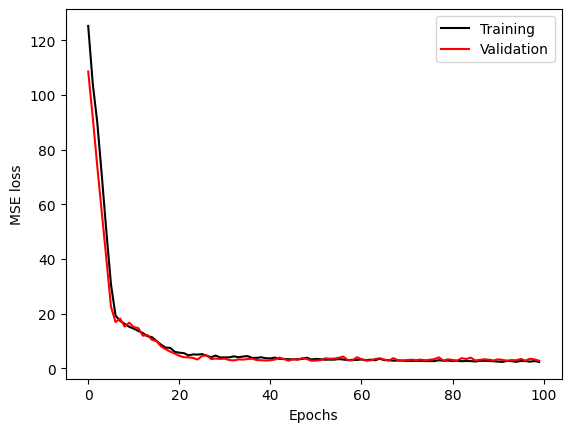

Average loss on the test dataset:  2.651052713394165


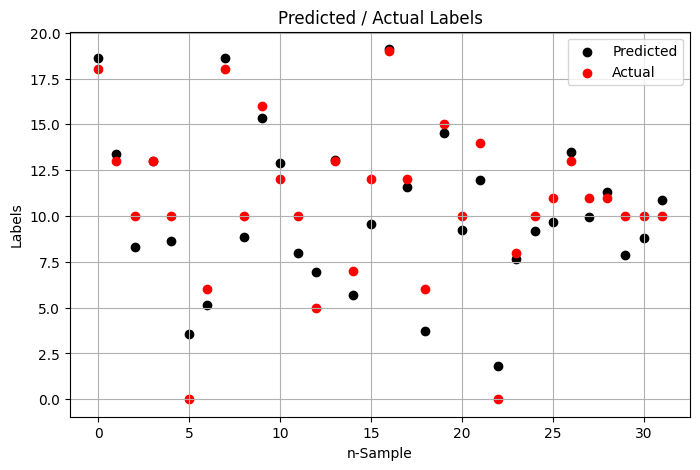

Tester: Regression model learning OK


In [8]:
# implement your solution BELOW

n_epochs = 100
loss_fn = nn.MSELoss()

lr_rate = 1e-3
optimizer = torch.optim.Adam(reg_model.parameters(), lr=lr_rate)

train_losses = []
val_losses = []

#size= len(dataloader_reg_train.dataset)


for epoch in range(n_epochs):

  reg_model.train()
  train_epoch_losses = []


  for x, y in dataloader_reg_train:
      optimizer.zero_grad()
      y_hat = reg_model(x)
      loss = loss_fn(y_hat, y)
      train_epoch_losses.append(loss)
      loss.backward()
      optimizer.step()


  train_epoch_losses = torch.tensor(train_epoch_losses)
  avg_epoch_loss = train_epoch_losses.mean()
  train_losses.append(avg_epoch_loss)

  reg_model.eval()
  val_epoch_losses = []

  for x, y in dataloader_reg_val:
    with torch.no_grad():
      y_hat = reg_model(x)

    loss = loss_fn(y_hat, y)
    val_epoch_losses.append(loss)

  val_epoch_losses = torch.tensor(val_epoch_losses)
  avg_epoch_loss = val_epoch_losses.mean()
  val_losses.append(avg_epoch_loss)

  #print(f'Tranining {epoch+1}/{n_epochs} done, training loss: {train_losses[-1]}, validation loss: {val_losses[-1]}')


plt.plot(train_losses, label='Training', color='black')
plt.plot(val_losses, label='Validation', color='red')
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.legend()
plt.show()


reg_model.eval()
test_losses = []
prediction_label_pairs = []
for x, y in dataloader_reg_test:
    with torch.no_grad():
      y_hat = reg_model(x)
    loss = loss_fn(y_hat, y)
    prediction_label_pairs.append(torch.concat((y_hat, y), dim=-1))
    test_losses.append(loss)

test_mse = torch.tensor(test_losses).mean()


print('Average loss on the test dataset: ', test_mse.item())
#print(prediction_label_pairs[0])



# Pár elem kiválasztása (Tensor)
predicted_labels_t = prediction_label_pairs[0][:, 0]
actual_labels_t = prediction_label_pairs[0][:, 1]

# Numpy tömbbé konvertálom...
predicted_labels = predicted_labels_t.numpy()
actual_labels = actual_labels_t.numpy()


plt.figure(figsize=(8, 5))
plt.scatter(range(len(predicted_labels)), predicted_labels, color='black', label='Predicted')
plt.scatter(range(len(actual_labels)), actual_labels, color='red', label='Actual')
plt.title('Predicted / Actual Labels')
plt.xlabel('n-Sample')
plt.ylabel('Labels')
plt.legend()
plt.grid(True)
plt.show()




# implement your solution ABOVE

tester.test('reg_model_learning', test_mse)

## **G**: Az adat-iterátorok létrehozása a klasszifikációs feladathoz

Hasonlóan a D) feladathoz, itt is három adat-iterátort kell létrehoznunk, azonban ezúttal egy kissé eltérő feladatot fogunk megtanulni megoldani, így a visszaadott tenzorok alakja / adattípusa is eltérő lesz. **Állítsd elő** a `dataloader_cl_train`, `dataloader_cl_val`, `dataloader_cl_test` nevű **iterátorokat**, melyek ugyancsak a C) részfeladatban elkészült tanító-, validációs- és teszthalmazokat tartalmazó tömböket járják be! A klasszifikációs feladatban input változókként az összes változót felhasználjuk az adatbázisban, kivéve a három harmadév végi jegyét a diákoknak (`G1`, `G2`, `G3` nevű, #30, #31 és #32 indexű oszlopok az eredeti adatbázis szövegfájlban). Címkeként három kategóriát definiálunk és az összes diákot besoroljuk ezekbe a kategóriákba:
- **"Gyengén teljesítő diákok"** kategória, #0 kategóriaindex: azon diákok kerülnek ide, akik átlagos jegye kisebb, mint 9.5.
- **"Közepesen teljesítő diákok"** kategória, #1 kategóriaindex: azon diákok kerülnek ide, akik legnagyobb jegye kisebb, mint 14, de nem tartoznak a "Gyengén teljesítő diákok" közé.
- **"Jól teljesítő diákok"** kategória, #2 kategóriaindex: azon diákok kerülnek ide, akik nem tartoznak a másik két kategóriába.

A fentiek alapján az iterátorok által visszaadott tenzorok alakja `(batch_size, 34)` és `(batch_size,)` lesz. Utóbbi (a címkéket tartalmazó tenzor) a diákok kategóriaindexét fogja tartalmazni (azaz 0, 1, vagy 2 értékeket, `torch.int64` adattípusban), előbbi pedig az adatbázis összes felhasznált változójának értékét a megfelelő mintaelemekre `torch.float32` adattípusban. `batch_size` ezúttal is a mintaelemek számát adja meg, ez kézzel beállítandó.

A **tanító és validációs halmazt felsoroló iterátorok véletlen sorrendben járják be** a hozzájuk tartozó mintaelemeket! A teszt halmazt felsoroló iterátor ne változtasson a `dataset_split_test` tömb sorrendjén!

In [9]:
# implement your solution BELOW

# Javítva numpy megoldásra for ciklus helyett.

def create_labels(features):
    labels = np.zeros(features.shape[0], dtype=np.int64)
    avg = np.mean(features[:, 30:33], axis=1)
    max_val = np.max(features[:, 30:33], axis=1)

    isZeroCategory = avg < 9.5
    isOneCategory = np.logical_and(~isZeroCategory, max_val < 14)

    labels[isZeroCategory] = 0
    labels[isOneCategory] = 1
    labels[~np.logical_or(isZeroCategory, isOneCategory)] = 2

    return labels


class MyCDataset(Dataset):
    def __init__(self, features, target):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.target = torch.tensor(target, dtype=torch.int64)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

#print(dataset_split_train.shape)

# TRAIN

train_cl_features = dataset_split_train[:, np.r_[:30, 33:37]]
val_cl_features = dataset_split_val[:, np.r_[:30, 33:37]]
test_cl_features = dataset_split_test[:, np.r_[:30, 33:37]]


#################
train_cl_labels = create_labels(dataset_split_train)
val_cl_labels = create_labels(dataset_split_val)
test_cl_labels = create_labels(dataset_split_test)


#train_cl_labels = np.zeros((dataset_split_train.shape[0]), dtype=np.int64)
#val_cl_labels = np.zeros((dataset_split_train.shape[0]), dtype=np.int64)
#test_cl_labels = np.zeros((dataset_split_test.shape[0]), dtype=np.int64)





###### DATASET ######

train_cl_dataset = MyCDataset(train_cl_features, train_cl_labels)
val_cl_dataset = MyCDataset(val_cl_features, val_cl_labels)
test_cl_dataset = MyCDataset(test_cl_features, test_cl_labels)

dataloader_cl_train = DataLoader(train_cl_dataset, batch_size=32, shuffle=True)
dataloader_cl_val = DataLoader(val_cl_dataset, batch_size=32, shuffle=True)
dataloader_cl_test = DataLoader(test_cl_dataset, batch_size=32, shuffle=True)




# implement your solution ABOVE

tester.test('cl_iter', dataloader_cl_train, dataloader_cl_val, dataloader_cl_test)

Tester: Dataset iterators for classification task OK


## **H**: A klasszifikációs neuronháló definiálása

**Definiáld a klasszifikációs feladathoz alkalmazandó neuronhálót megvalósító osztályt**, mely a regressziós neuronhálót implementáló osztályhoz hasonlóan, az általános `torch.nn.Module` osztály leszármazottja! Példányosítsd az új osztályt és add értékül a `cl_model` nevű változónak a példányt!

A klasszifikációs neuronháló **tartalmazzon 3 teljesen összekötött réteget! Az első kettő réteg tartalmazzon egyenként 30 és 20 neuront és alkalmazza a ReLU aktivációs függvényt a rétegek után!** Az utolsó réteget a háromkategóriás klasszifikációnak megfelelően kell kialakítani! Lásd a "HF1 GYIK" fórumot!

In [10]:
# implement your solution BELOW

class MyClassificationModel(nn.Module):
  def __init__(self, input_dim):
        super().__init__()
        self.linear_relu_layers = nn.Sequential(
            nn.Linear(input_dim, 30),
            nn.ReLU(),
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )
        self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
      out = self.linear_relu_layers(x)
      out = self.softmax(out)
      return out

cl_model = MyClassificationModel(34)



# implement your solution ABOVE

tester.test('cl_model_architecture', cl_model)

Tester: Classification model architecture OK


## **I**: A háló betanítása (multi-class) klasszifikációs feladatra

**Tanítsd be a** `cl_model` **neuronhálót** a tanítóhalmazon a `dataloader_cl_train` iterátor segítségével és alkalmazd a `dataloader_cl_val` iterátort a validációhoz!

Alkalmazd a multi-class klasszifikációkor szokásosan használt **cross-entropy költséget**! **Mérd le minden epoch-ban a tanító- és a validációs halmazon mért költségeket, majd a tanítás végeztével rajzold ki ezeknek az értékeknek a tanítás során való alakulását egy közös grafikonon!** A grafikonon a jelmagyarázat meglétére és a görbék könnyű elkülöníthetőségére figyelj ezúttal is!

A tanítást ezúttal az **early stopping** technika állítsa le! Amennyiben adott számú epoch-on keresztül (`patience`) nem javul a validációs költség, érjen véget a betanítás és **állítsuk vissza a `cl_model` súlyait abból az epoch-ból, amikor a legjobb volt a validációs költség!** Mindez automatikusan történjen!

A betanítás végeztével **mérd le az átlagos költséget a teljes teszthalmazon** és add értékül a kapott számot a `test_ce` változónak!

**Számold ki az _accuracy_ (pontosság) metrikát is a teszthalmaz elemein** és add értékül a kapott számot a `test_acc` változónak! Az _accuracy_ metrika a helyesen klasszifikált mintaelemek arányát adja meg. Például, ha 150 mintaelem kategóriájának becslésekor 75 esetben találtuk el a helyes kategóriát, az _accuracy_ értéke 0.5 lesz.

Ezt követően, **válassz néhány mintaelemet a teszthalmazból** (például a `dataloader_cl_test` iterátor segítségével) és **adj becslést a címkéjükre** (a kategória indexére) az input változók értékei alapján, majd **írasd ki az egyes mintaelemekre a becsült és az igazi címkéjüket** (a kategóriák indexét)! Így példákon is láthatjuk, hogy mennyire ad jó becsléseket a neuronhálónk.

Végezetül, **számold ki a háló teszthalmazon vett konfúziós mátrixát és rajzold ki azt**! A konfúziós mátrix egy k x k méretű mátrix k kategória esetén, ahol az `[i,j]` indexű elem megadja, hogy az adathalmazon a modellünk hány `i` kategóriába tartozó mintaelemet becsült a `j` kategóriába. A modellünk jó teljesítményét jelzi, ha minél több elem kerül a konfúziós mátrix főátlójába. A számoláshoz felhasználhatsz külső könyvtárat is, de NumPy-ban is megoldható. A kirajzoláshoz használható például a `matplotlib.pyplot` csomag `imshow` függvénye. Figyelj rá, hogy a grafikonon világosan látszon, hogy melyik tengely sorolja fel az igazi kategóriákat és melyik a becsült kategóriákat, látszanak a sorok és oszlopok végén a kategóriák indexei és a cellákban az odatartozó mintaelemek darabszáma!


Tranining 1/100 done, training loss: 1.1063774824142456, validation loss: 1.0863443613052368
Tranining 2/100 done, training loss: 1.0906115770339966, validation loss: 1.0814787149429321
Tranining 3/100 done, training loss: 1.0868569612503052, validation loss: 1.0839530229568481
Tranining 4/100 done, training loss: 1.0850142240524292, validation loss: 1.0840798616409302
Tranining 5/100 done, training loss: 1.0785166025161743, validation loss: 1.088551640510559
Tranining 6/100 done, training loss: 1.074164628982544, validation loss: 1.0915333032608032
Tranining 7/100 done, training loss: 1.0718023777008057, validation loss: 1.0813385248184204
Tranining 8/100 done, training loss: 1.0679537057876587, validation loss: 1.0881481170654297
Tranining 9/100 done, training loss: 1.0611540079116821, validation loss: 1.0842541456222534
Tranining 10/100 done, training loss: 1.0629851818084717, validation loss: 1.0832791328430176
Tranining 11/100 done, training loss: 1.0597842931747437, validation lo

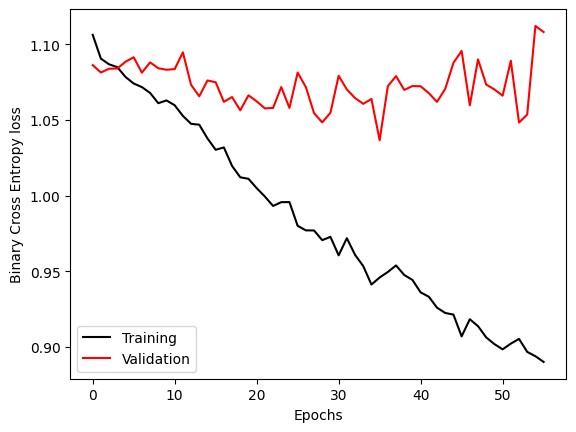

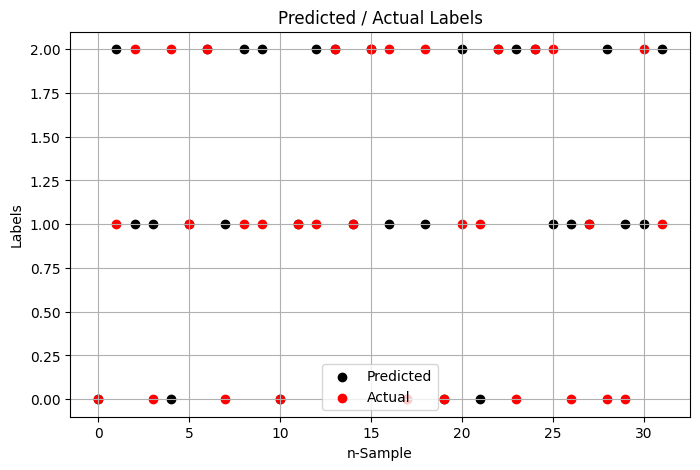

torch.Size([79, 2])


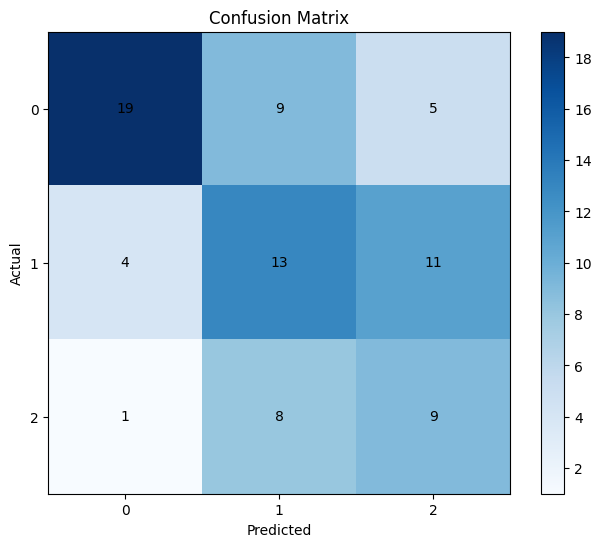

Tester: Classification model learning OK


In [12]:
# implement your solution BELOW
from sklearn.metrics import confusion_matrix
def train(model, train_dataloader, val_dataloader, optimizer, loss_fn, n_epochs=10, delta=0.01, patience=10):
  train_losses = []
  val_losses = []

  best_loss = np.inf
  best_loss_cl_model = None #None, szóval utólag tudom ellenőrizni
  no_improvement_count = 0

  for epoch in range(n_epochs):
    model.train()
    train_epoch_losses = []

    for x, y in train_dataloader:
      optimizer.zero_grad()
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      train_epoch_losses.append(loss)
      loss.backward()
      optimizer.step()

    train_epoch_losses = torch.tensor(train_epoch_losses)
    avg_epoch_loss = train_epoch_losses.mean()
    train_losses.append(avg_epoch_loss)

    model.eval()
    val_epoch_losses = []

    for x, y in val_dataloader:
      with torch.no_grad():
        y_hat = model(x)

      loss = loss_fn(y_hat, y)
      val_epoch_losses.append(loss)

    val_epoch_losses = torch.tensor(val_epoch_losses)
    avg_epoch_loss = val_epoch_losses.mean()
    val_losses.append(avg_epoch_loss)

    if avg_epoch_loss + delta < best_loss:
      best_loss = avg_epoch_loss
      best_loss_cl_model = model.state_dict()
      no_improvement_count = 0
      #torch.save(model.state_dict(), 'best_model.pth')
    else:
      no_improvement_count += 1

    print(f'Tranining {epoch+1}/{n_epochs} done, training loss: {train_losses[-1]}, validation loss: {val_losses[-1]}')

    if no_improvement_count >= patience:
      print('Stopped by early stopping.')
      print('Best validation loss: ', best_loss.item())
      if best_loss_cl_model:
                model.load_state_dict(best_loss_cl_model)
      return train_losses, val_losses

  return train_losses, val_losses

n_epochs = 100
loss_cl_fn = nn.CrossEntropyLoss()
learning_rate = 0.001

optimizer = torch.optim.Adam(cl_model.parameters(), lr=learning_rate)

train_losses, val_losses = train(cl_model, dataloader_cl_train, dataloader_cl_val, optimizer, loss_cl_fn, n_epochs=n_epochs, delta=0.001, patience=20)


plt.plot(train_losses, label='Training', color='black')
plt.plot(val_losses, label='Validation', color='red')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy loss')
plt.legend()
plt.show()

# Teljes teszthalmaz evaluation
cl_model.eval()
accuracy = []
test_cl_losses = []
prediction_label_pairs = []
for x, y in dataloader_cl_test:
    with torch.no_grad():
        y_hat = cl_model(x)
        loss = loss_cl_fn(y_hat, y)
        test_cl_losses.append(loss)

        prediction = torch.argmax(y_hat, dim=1)
        accuracy.append((prediction == y).to(torch.float32))

        prediction_label_pairs.append(torch.stack((prediction, y), dim=-1))

test_acc = (torch.cat(accuracy).mean()).item()
test_ce = torch.tensor(test_cl_losses).mean().item()



# Pár elem kiválasztása (Tensor)
predicted_cl_labels_t = prediction_label_pairs[0][:, 0]
actual_cl_labels_t = prediction_label_pairs[0][:, 1]

# Numpy tömbbé konvertálom...
predicted_cl_labels = predicted_cl_labels_t.numpy()
actual_cl_labels = actual_cl_labels_t.numpy()


plt.figure(figsize=(8, 5))
plt.scatter(range(len(predicted_cl_labels)), predicted_cl_labels, color='black', label='Predicted')
plt.scatter(range(len(actual_cl_labels)), actual_cl_labels, color='red', label='Actual')
plt.title('Predicted / Actual Labels')
plt.xlabel('n-Sample')
plt.ylabel('Labels')
plt.legend()
plt.grid(True)
plt.show()




prediction_label_pairs = torch.cat(prediction_label_pairs, 0)
print(prediction_label_pairs.shape)
conf_matrix = confusion_matrix(prediction_label_pairs[:,1], prediction_label_pairs[:,0])

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')

plt.colorbar()

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.xticks(np.arange(len(conf_matrix)), np.arange(len(conf_matrix)))
plt.yticks(np.arange(len(conf_matrix)), np.arange(len(conf_matrix)))


for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix)):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')

plt.title('Confusion Matrix')
plt.show()
# implement your solution ABOVE

tester.test('cl_model_learning', test_ce, test_acc)